In [3]:
import pandas as pd
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import os
import numpy as np

import faiss

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from tqdm import tqdm
tqdm.pandas()


/Users/vinetiger/Работа💸/Авито/PriceAlchemists/PriceAlchemists/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
EMBEDDING_SHAPE = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
df = pd.read_csv('/Users/vinetiger/Работа💸/Авито/PriceAlchemists/PriceAlchemists/backend/data/aaa_advml_final_project.csv')

In [6]:
df = df.sample(frac=0.1)

In [7]:
model = models.resnet50(pretrained=True)
model.eval()

model = torch.nn.Sequential(*list(model.children())[:-2])

model = nn.Sequential(
    model,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(2048, EMBEDDING_SHAPE)
)

model = model.to(device)

/Users/vinetiger/Работа💸/Авито/PriceAlchemists/PriceAlchemists/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vinetiger/Работа💸/Авито/PriceAlchemists/PriceAlchemists/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [9]:
def get_img_embedding(img_idx, model, transform):
  img_path = f'/Users/vinetiger/Работа💸/Авито/PriceAlchemists/PriceAlchemists/backend/data/images/{img_idx}.jpg'
  img = Image.open(img_path).convert('RGB')
  img = transform(img).unsqueeze(0)
  img = img.to(device)
  with torch.no_grad():
      embedding = model(img).squeeze().cpu().numpy()
  return embedding

In [10]:
df['Embeding'] = df['image_id'].progress_apply(lambda img_idx: get_img_embedding(img_idx, model, transform))

  0%|          | 0/6146 [00:00<?, ?it/s]

100%|██████████| 6146/6146 [02:49<00:00, 36.24it/s]


# Просмотр изображений на сходство

In [12]:
embedding_data = np.vstack(df['Embeding'].values)
index = faiss.IndexFlatL2(EMBEDDING_SHAPE)
index.add(embedding_data)

In [16]:
def show_nearest_neighbors(query_idx, df, index, k=5):
    """
    Визуализирует изображение с индексом `query_idx` и k ближайших к нему изображений.
    Показывает расстояния до каждого из соседей.

    Parameters:
        query_idx (int): индекс в датафрейме df.
        df (pd.DataFrame): датафрейм с колонками 'img_idx' и 'Embedding'.
        index (faiss.Index): FAISS-индекс.
        k (int): число ближайших соседей (включая сам запрос).
    """
    # Получаем вектор запроса
    query_embedding = df.iloc[query_idx]['Embeding'].reshape(1, -1)

    # Находим k ближайших
    distances, indices = index.search(query_embedding, k)

    # Визуализация
    plt.figure(figsize=(3 * k, 4))
    for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
        img_id = df.iloc[idx]['image_id']
        img_path = f'/Users/vinetiger/Работа💸/Авито/PriceAlchemists/PriceAlchemists/backend/data/images/{img_id}.jpg'
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            print(f"Could not open image: {img_path}")
            continue
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(f'Запрос\nidx={idx}')
        else:
            plt.title(f'#{i}\nD={dist:.2f}')
    plt.tight_layout()
    plt.show()


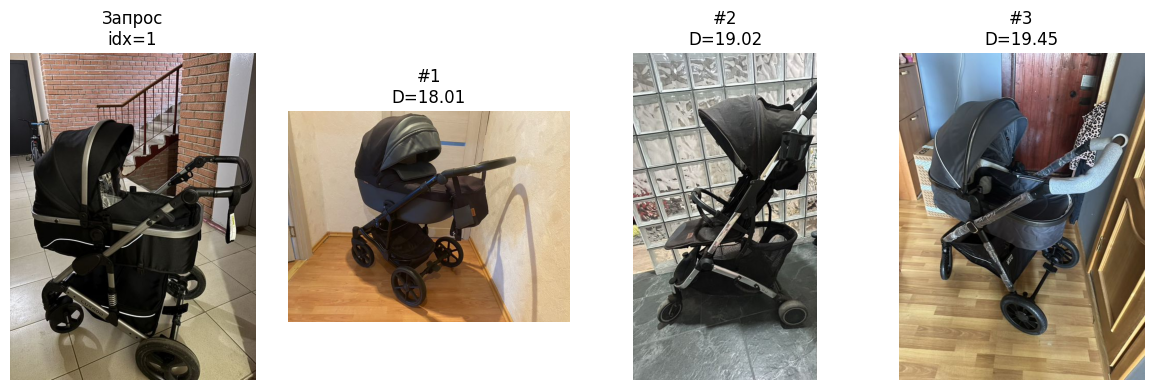

In [25]:
show_nearest_neighbors(1, df, index, k=4)

In [27]:
df

,item_id,external_id,logical_category,category_name,subcategory_name,microcat_name,Param1,Param2,Param3,Param4,price,title,description,image_id,Embeding
40448,2090101250655,7346350948,Goods.Fashion,Личные вещи,"Одежда, обувь, аксессуары",Кеды,Мужская обувь,Кеды,NaN,NaN,1.0,Rick owens jumbo low,Продаю кеды rick owens jumbo low. 40 размер.\n...,43866240600,"[0.5716758, -0.7819363, -0.6686881, 0.51002836..."
12101,2089992750538,7359980484,Goods.GoodsForChildren,Личные вещи,Товары для детей и игрушки,Прогулочные коляски,Детские коляски,Прогулочные коляски,NaN,NaN,4000.0,Коляска,Коляска в хорошем состоянии,43860593105,"[0.752718, -0.46869904, -1.1022272, 0.65271115..."
61079,2090082750085,7326351682,Goods.GoodsForChildren,Личные вещи,Товары для детей и игрушки,Фигурки и наборы,Игрушки,Фигурки и наборы,NaN,NaN,10.0,Littlest pet shop LPS G7 #132,Доставка,43865128756,"[0.48133495, -0.6257758, -0.5482076, 0.6521305..."
50162,2090098502041,7382164069,Goods.Fashion,Личные вещи,"Одежда, обувь, аксессуары",Пиджаки и костюмы,Мужская одежда,Пиджаки и костюмы,NaN,NaN,2500.0,Пиджак мужской Zara шерсть,"Мужской пиджак Zara из шерсти, размер EUR50 ( ...",43863917408,"[0.4360539, -0.07215132, -0.39223397, 0.597448..."
33677,2090017000146,7330635512,Goods.GoodsForChildren,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,Постельные принадлежности,NaN,NaN,NaN,500.0,Балдахин на кроватку с держателем comfort baby,"Воздушный и невесомый, хорошо пропускающий воз...",43860742370,"[0.8837005, -0.43137535, -0.3096458, 1.1819826..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12240,2090017001017,7369849272,Goods.Telecom,Электроника,Телефоны,Мобильные телефоны,Мобильные телефоны,NaN,NaN,NaN,94990.0,"iPhone 15 Pro Max, 256 ГБ",🔥 ЛОВИ ВЫГОДУ! 🔥 ВЫГОДНЫЕ УСЛОВИЯ TRADE-IN! 🔥 ...,43862181819,"[0.6941744, -0.5445858, -1.017851, 0.5360805, ..."
1351,2089934751919,7375444662,Goods.InformationTechnology,Электроника,Товары для компьютера,Контроллеры,Комплектующие,Контроллеры,NaN,NaN,90.0,AZC399-04S azc399-04s,AZC399-04S C30NL,43858424678,"[0.5662243, -0.44124413, -0.84762704, -0.08682..."
34193,2090085000331,7339311441,Goods.AudioVideo,Электроника,Аудио и видео,Наушники,Наушники,NaN,NaN,NaN,4301.0,Наушники apple airpods pro 1 оригинал,"Наушники в отличном состоянии,оригинал!!!!",43865378400,"[0.37595242, -0.59225065, -0.92793065, 0.15743..."
9402,2090042250455,7356746913,Goods.GoodsForChildren,Личные вещи,Товары для детей и игрушки,Прогулочные коляски,Детские коляски,Прогулочные коляски,NaN,NaN,29500.0,Maxi-Cosi Коляска детская прогулочная Leona Es...,Maxi-Cosi Коляска детская прогулочная Leona Es...,43863471630,"[0.4762707, -0.35713428, -0.7874192, 0.3336812..."
